## Non Farm Payroll Time Series

In [ ]:
!pip install alpha_vantage
!pip install prophet
!pip install --upgrade statsmodels

In [ ]:
import os 
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from alpha_vantage.foreignexchange import ForeignExchange
from pprint import pprint

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## The google drive mounting is for using local library

In [ ]:
try:
    # Mount your google drive in google colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Insert the directory to syspath
    import sys
    sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks')
except:
    pass

In [ ]:
from time_series_utils import timeseries_evaluation_metrics_func,\
                          create_proph_train_test, find_best_Prophet_model, \
                          find_best_ETS_model, find_best_ARIMA_model, find_best_SARIMAX_model,\
                          load_hyperparam, save_hyperparam

## NON-FARM PAYROLL

In [ ]:
suffix = 'non_farm_payroll'

In [ ]:
api_key = 123 

In [ ]:
import requests
try: 
    with open('drive/MyDrive/ALPHAVANTAGE_API_KEY.txt') as f:
        api_key = f.readline()
except:
    api_key = os.environ.get('ALPHAVANTAGE_API_KEY')

In [ ]:
url = f'https://www.alphavantage.co/query?function=NONFARM_PAYROLL&apikey={api_key}'
r = requests.get(url)

In [ ]:
data = r.json()
print(data)

{'name': 'Total Nonfarm Payroll', 'interval': 'monthly', 'unit': 'thousands of persons', 'data': [{'date': '2022-04-01', 'value': '150983'}, {'date': '2022-03-01', 'value': '149912'}, {'date': '2022-02-01', 'value': '149143'}, {'date': '2022-01-01', 'value': '147505'}, {'date': '2021-12-01', 'value': '150352'}, {'date': '2021-11-01', 'value': '150210'}, {'date': '2021-10-01', 'value': '149310'}, {'date': '2021-09-01', 'value': '147651'}, {'date': '2021-08-01', 'value': '146947'}, {'date': '2021-07-01', 'value': '146452'}, {'date': '2021-06-01', 'value': '146493'}, {'date': '2021-05-01', 'value': '145304'}, {'date': '2021-04-01', 'value': '144358'}, {'date': '2021-03-01', 'value': '143308'}, {'date': '2021-02-01', 'value': '142129'}, {'date': '2021-01-01', 'value': '140974'}, {'date': '2020-12-01', 'value': '143605'}, {'date': '2020-11-01', 'value': '144115'}, {'date': '2020-10-01', 'value': '143565'}, {'date': '2020-09-01', 'value': '141958'}, {'date': '2020-08-01', 'value': '140727'},

In [ ]:
df4 = pd.DataFrame(data['data'])
df4.head()

date   value
0  2022-04-01  150983
1  2022-03-01  149912
2  2022-02-01  149143
3  2022-01-01  147505
4  2021-12-01  150352

Make the time series ascending

In [ ]:
df4 = df4[::-1] 
df4.head()

date  value
999  1939-01-01  29296
998  1939-02-01  29394
997  1939-03-01  29804
996  1939-04-01  29786
995  1939-05-01  30145

In [ ]:
df4.date = pd.to_datetime(df4.date)
df4.value = df4.value.astype(int)

In [ ]:
df4.dtypes

date     datetime64[ns]
value             int64
dtype: object

In [ ]:
df4.tail()

date   value
4 2021-12-01  150352
3 2022-01-01  147505
2 2022-02-01  149143
1 2022-03-01  149912
0 2022-04-01  150983

In [ ]:
df4.shape

(1000, 2)

In [ ]:
df4 = df4.set_index('date')
df4

value
date              
1939-01-01   29296
1939-02-01   29394
1939-03-01   29804
1939-04-01   29786
1939-05-01   30145
...            ...
2021-12-01  150352
2022-01-01  147505
2022-02-01  149143
2022-03-01  149912
2022-04-01  150983

[1000 rows x 1 columns]

In [ ]:
df4.index

DatetimeIndex(['1939-01-01', '1939-02-01', '1939-03-01', '1939-04-01',
               '1939-05-01', '1939-06-01', '1939-07-01', '1939-08-01',
               '1939-09-01', '1939-10-01',
               ...
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='date', length=1000, freq=None)

In [ ]:
df4.columns = ['payroll']

In [ ]:
df4.head()

payroll
date               
1939-01-01    29296
1939-02-01    29394
1939-03-01    29804
1939-04-01    29786
1939-05-01    30145

<AxesSubplot:xlabel='date'>

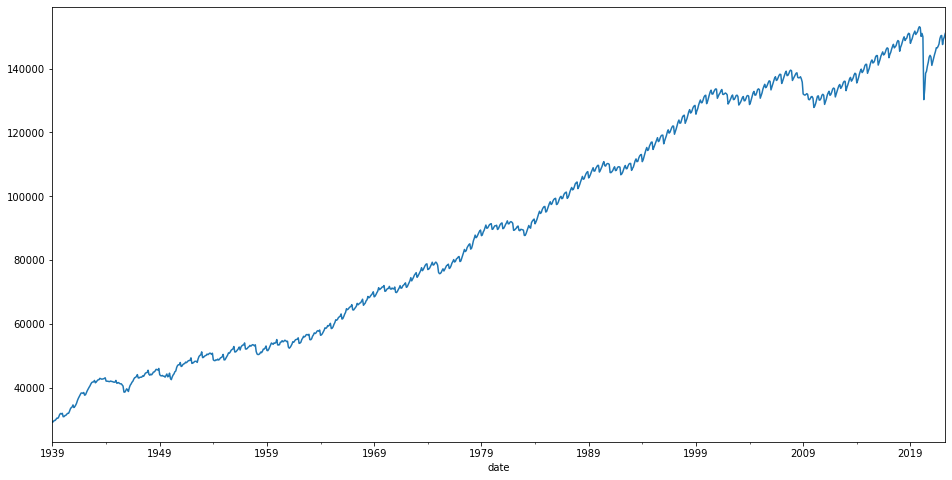

In [ ]:
df4['payroll'].plot(figsize=(16,8))

In [ ]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2021,4,30)
test_dataset_end = datetime(2022,5,1)

In [ ]:
train_data = df4[:train_dataset_end]
test_data = df4[train_dataset_end+timedelta(days=0):test_dataset_end]

In [ ]:
prediction_length = len(test_data)

In [ ]:
prediction_length

12

In [ ]:
train_data.tail(2)

payroll
date               
2021-03-01   143308
2021-04-01   144358

Save train and test data to filesystem

In [ ]:
train_data_filename = f'train_data_{suffix}.csv'
test_data_filename = f'test_data_{suffix}.csv'

In [ ]:
train_data.to_csv(train_data_filename, encoding='utf-8')
test_data.to_csv(test_data_filename, encoding='utf-8')

Reload train and test data from filesystem

In [ ]:
train_data = pd.read_csv(train_data_filename, parse_dates=['date'], index_col='date')
train_data = pd.read_csv(train_data_filename, parse_dates=['date'], index_col='date')

In [ ]:
train2_data = train_data[:-(prediction_length)]
val_data = train_data[-(prediction_length):]

In [ ]:
prediction_length, len(val_data), len(train_data), len(train2_data)

(12, 12, 988, 976)

In [ ]:
test_data

payroll
date               
2021-05-01   145304
2021-06-01   146493
2021-07-01   146452
2021-08-01   146947
2021-09-01   147651
2021-10-01   149310
2021-11-01   150210
2021-12-01   150352
2022-01-01   147505
2022-02-01   149143
2022-03-01   149912
2022-04-01   150983

In [ ]:
# Value Columns to be used in all models tuning
value_col = 'payroll'

In [ ]:
import statsmodels.api as sm 
from statsmodels.tsa.seasonal import seasonal_decompose

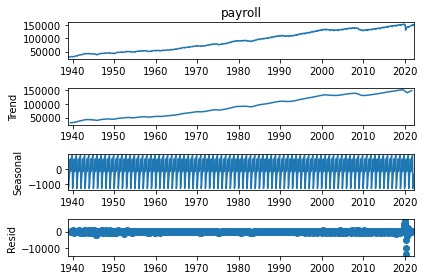

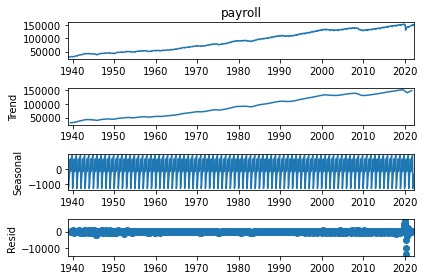

In [ ]:
seasonal_decompose(df4[value_col], model='additive', period=12).plot() 

## Holt Winters ExponentialSmoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
best_ETS_RMSE_model, best_RMSE, best_ETS_RMSE_params, best_ETS_WMAPE_model, best_WMAPE, best_ETS_WMAPE_params\
 = find_best_ETS_model(train2_data, val_data, value_col=value_col, seasonal_periods=[12])

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency inform

In [ ]:
best_WMAPE, best_ETS_WMAPE_params

(0.15314774693243344, ('mul', 'mul', 12))

In [ ]:
best_RMSE, best_ETS_RMSE_params

(23927.637537266517, ('mul', 'mul', 12))

In [ ]:
# best_RMSE, best_ETS_params
# (23927.637537266517, ('mul', 'mul', 12))

We forward forecast after we found the best hyperparam with train2 and validation data.

In [ ]:
trend, seasonal, seasonal_period = best_ETS_RMSE_params

ETS_model_updated = ExponentialSmoothing(train_data[value_col], trend=trend, seasonal=seasonal,\
                                         seasonal_periods=seasonal_period).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
test_pred_ETS = ETS_model_updated.forecast(len(test_data))
test_pred_ETS

2021-05-01    147784.436050
2021-06-01    149218.163210
2021-07-01    147601.749436
2021-08-01    147644.105336
2021-09-01    147875.675689
2021-10-01    148730.527590
2021-11-01    148954.118227
2021-12-01    148488.136941
2022-01-01    145464.351048
2022-02-01    146282.839176
2022-03-01    146839.552970
2022-04-01    145079.705742
Freq: MS, dtype: float64

In [ ]:
test_data['Predicted_ETS'] = test_pred_ETS

<AxesSubplot:xlabel='date'>

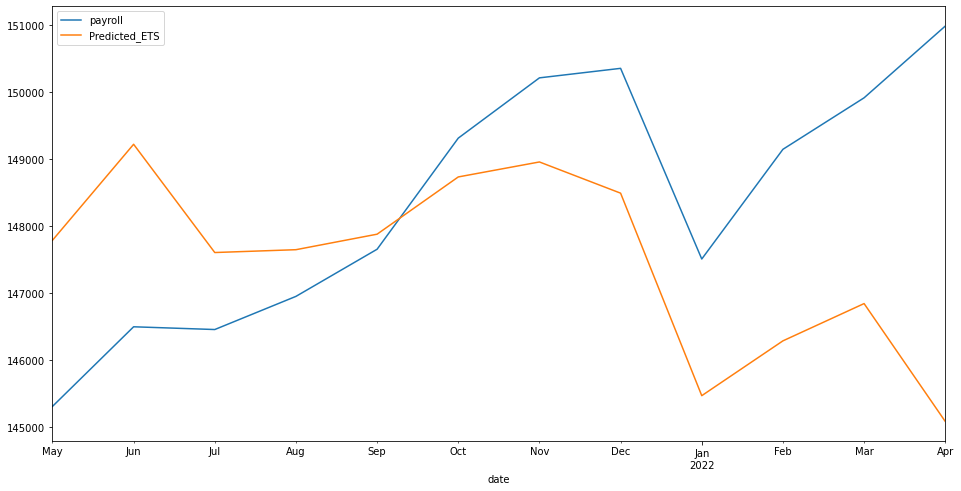

In [ ]:
test_data[[value_col, 'Predicted_ETS']].plot(figsize=(16,8))

## ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima_model_filename = f"arima_{suffix}_hyper_params"

In [ ]:
# run once them comment out
# best_params = (8, 1, 2)
# save_hyperparam(arima_model_filename, best_params)

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(arima_model_filename)
except:
    pass 

In [ ]:
# # to recalculate hyperparameters
# best_params = None 

In [ ]:
best_ARIMA_RMSE_model, best_RMSE, best_pdq_RMSE, best_ARIMA_WMAPE_model, best_WMAPE, best_pdq_WMAPE\
 = find_best_ARIMA_model(train2_data, val_data, value_col=value_col, best_params=best_params)

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmod

In [ ]:
best_pdq_WMAPE, best_WMAPE

((6, 0, 0), 0.0335485172141669)

In [ ]:
best_pdq_RMSE, best_RMSE

((6, 0, 0), 5077.632233359723)

In [ ]:
# save best hyperparam to file 
save_hyperparam(arima_model_filename, best_pdq_RMSE)

In [ ]:
# best_pdq, best_RMSE
# ((8, 1, 2), 3218.125490381145)

We update the model with the new data (whole train data)

In [ ]:
model_ARIMA = ARIMA(train_data[value_col], order=best_pdq_RMSE).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
test_pred_arima = model_ARIMA.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_ARIMA'] = test_pred_arima

<AxesSubplot:xlabel='date'>

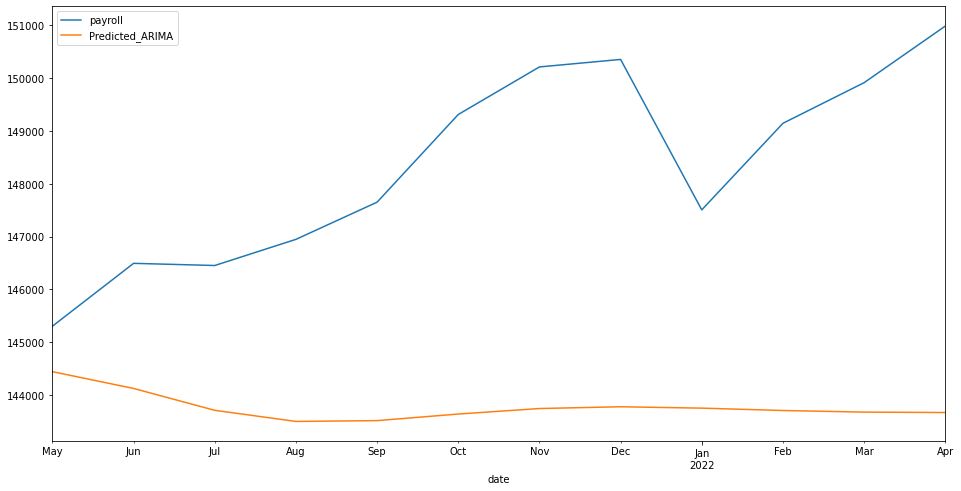

In [ ]:
test_data[[value_col, 'Predicted_ARIMA']].plot(figsize=(16,8))

## SARIMAX model

In [ ]:
best_pdq = best_pdq_RMSE

In [ ]:
# seasonal period from ETS result
# seasonal_period = best_ETS_RMSE_params[2]
seasonal_period = best_ETS_RMSE_params[2]

In [ ]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
sarimax_model_filename = f"sarimax_{suffix}_hyper_params"

In [ ]:
# run once then comment out 
# best_params = (1, 0, 2, 12)
# save_hyperparam(sarimax_model_filename, best_params)

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(sarimax_model_filename)
except:
    pass 

In [ ]:
# # we force the hyperparmater recalculation 
# best_params = None

We find hyperparams with train2 and validation data.

In [ ]:
best_SARIMAX_model, best_RMSE, best_PDQS = find_best_SARIMAX_model(train2_data, val_data, best_pdq, \
                                                  value_col=value_col, season_period=seasonal_period,\
                                                  best_params=best_params)

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53037D+03    |proj g|=  9.03569D+03

At iterate    5    f=  1.40325D+01    |proj g|=  6.73761D+00

At iterate   10    f=  9.09763D+00    |proj g|=  5.54635D-01

At iterate   15    f=  8.57374D+00    |proj g|=  8.82059D-02

At iterate   20    f=  8.54559D+00    |proj g|=  2.41451D-02

At iterate   25    f=  8.53552D+00    |proj g|=  7.01827D-02

At iterate   30    f=  8.46134D+00    |proj g|=  2.63164D-01

At iterate   35    f=  8.43972D+00    |proj g|=  4.04467D-04

At iterate   40    f=  8.43899D+00    |proj g|=  8.21569D-03

At iterate   45    f=  8.43892D+00    |proj g|=  5.10156D-04

At iterate   50    f=  8.43868D+00    |proj g|=  6.70075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53037D+03    |proj g|=  9.03569D+03

At iterate    5    f=  1.19493D+01    |proj g|=  5.04078D+00

At iterate   10    f=  8.71519D+00    |proj g|=  5.14249D-01

At iterate   15    f=  8.30793D+00    |proj g|=  3.14607D-02

At iterate   20    f=  8.30265D+00    |proj g|=  2.36182D-02

At iterate   25    f=  8.29109D+00    |proj g|=  3.71156D-02

At iterate   30    f=  8.25369D+00    |proj g|=  3.12904D-02

At iterate   35    f=  8.24885D+00    |proj g|=  1.23230D-03

At iterate   40    f=  8.24822D+00    |proj g|=  6.85356D-03

At iterate   45    f=  8.24800D+00    |proj g|=  4.30047D-04


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  8.24783D+00    |proj g|=  1.09088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   1.091D-02   8.248D+00
  F =   8.2478277245100937     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53037D+03    |proj g|=  9.03569D+03

At iterate    5    f=  1.07560D+01    |proj g|=  3.48427D+00

At iterate   10    f=  8.42482D+00    |proj g|=  1.86400D-01

At iterate   15    f=  8.22832D+00    |proj g|=  2.70299D-02

At iterate   20    f=  8.22049D+00    |proj g|=  4.08050D-02

At iterate   25    f=  8.21770D+00    |proj g|=  1.53893D-02

At iterate   30    f=  8.21346D+00    |proj g|=  3.03135D-02

At iterate   35    f=  8.19400D+00    |proj g|=  4.69958D-02

At iterate   40    f=  8.18408D+00    |proj g|=  8.26627D-04

At iterate   45    f=  8.18397D+00    |proj g|=  1.05161D-03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.18392D+00    |proj g|=  1.35888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   1.359D-03   8.184D+00
  F =   8.1839183597186373     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23141D+00    |proj g|=  7.31795D-02

At iterate    5    f=  8.21094D+00    |proj g|=  2.95384D-02

At iterate   10    f=  8.20606D+00    |proj g|=  5.95774D-03

At iterate   15    f=  8.17604D+00    |proj g|=  1.13460D-02

At iterate   20    f=  8.17571D+00    |proj g|=  4.20336D-04

At iterate   25    f=  8.17553D+00    |proj g|=  6.52667D-03

At iterate   30    f=  8.16734D+00    |proj g|=  5.22904D-02

At iterate   35    f=  8.15356D+00    |proj g|=  9.37830D-04

At iterate   40    f=  8.15355D+00    |proj g|=  2.49655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87039D+00    |proj g|=  8.86809D-01

At iterate    5    f=  8.69413D+00    |proj g|=  5.05458D-01

At iterate   10    f=  8.23348D+00    |proj g|=  8.38657D-02

At iterate   15    f=  8.16457D+00    |proj g|=  6.07396D-02

At iterate   20    f=  8.14617D+00    |proj g|=  2.97921D-03

At iterate   25    f=  8.14252D+00    |proj g|=  2.41831D-02

At iterate   30    f=  8.14048D+00    |proj g|=  3.82944D-04

At iterate   35    f=  8.14043D+00    |proj g|=  4.26830D-03

At iterate   40    f=  8.13773D+00    |proj g|=  4.46315D-02

At iterate   45    f=  8.12694D+00    |proj g|=  4.47728D-04


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.12694D+00    |proj g|=  3.00235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   3.002D-05   8.127D+00
  F =   8.1269395386054271     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47378D+00    |proj g|=  4.39517D-01

At iterate    5    f=  8.16068D+00    |proj g|=  4.06786D-02

At iterate   10    f=  8.14574D+00    |proj g|=  9.86765D-03

At iterate   15    f=  8.14474D+00    |proj g|=  9.32784D-03

At iterate   20    f=  8.13680D+00    |proj g|=  1.11119D-02

At iterate   25    f=  8.13650D+00    |proj g|=  3.24728D-04

At iterate   30    f=  8.13648D+00    |proj g|=  1.94950D-03

At iterate   35    f=  8.13485D+00    |proj g|=  1.90328D-02

At iterate   40    f=  8.12287D+00    |proj g|=  7.32587D-03

At iterate   45    f=  8.12274D+00    |proj g|=  1.28759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53037D+03    |proj g|=  9.03569D+03

At iterate    5    f=  1.05217D+01    |proj g|=  3.73879D+00

At iterate   10    f=  8.27508D+00    |proj g|=  1.19302D-01

At iterate   15    f=  8.12172D+00    |proj g|=  8.09276D-03

At iterate   20    f=  8.11216D+00    |proj g|=  2.23234D-02

At iterate   25    f=  8.10782D+00    |proj g|=  8.55226D-04

At iterate   30    f=  8.10729D+00    |proj g|=  2.25124D-03

At iterate   35    f=  8.10309D+00    |proj g|=  3.73081D-03

At iterate   40    f=  8.08454D+00    |proj g|=  1.32457D-02

At iterate   45    f=  8.07888D+00    |proj g|=  1.92865D-03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.06506D+00    |proj g|=  2.22126D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   2.221D-02   8.065D+00
  F =   8.0650553060458900     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18332D+03    |proj g|=  4.34693D+03

At iterate    5    f=  1.01706D+01    |proj g|=  1.96176D+00

At iterate   10    f=  8.22896D+00    |proj g|=  6.02270D-02
Exception: LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68116D+03    |proj g|=  5.34152D+03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.87819D+00    |proj g|=  1.93895D+00

At iterate   10    f=  8.25204D+00    |proj g|=  8.89089D-02

At iterate   15    f=  8.10885D+00    |proj g|=  2.45726D-02

At iterate   20    f=  8.10062D+00    |proj g|=  1.52440D-02

At iterate   25    f=  8.09422D+00    |proj g|=  1.99209D-03

At iterate   30    f=  8.09354D+00    |proj g|=  1.37816D-03

At iterate   35    f=  8.09250D+00    |proj g|=  3.22406D-03

At iterate   40    f=  8.07511D+00    |proj g|=  4.66378D-03

At iterate   45    f=  8.07403D+00    |proj g|=  2.40570D-03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.07161D+00    |proj g|=  1.01884D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     63      1     0     0   1.019D-02   8.072D+00
  F =   8.0716100046946906     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31741D+00    |proj g|=  1.01859D-01

At iterate    5    f=  8.18750D+00    |proj g|=  2.18744D-02

At iterate   10    f=  8.17797D+00    |proj g|=  7.38073D-03

At iterate   15    f=  8.15422D+00    |proj g|=  5.26591D-02

At iterate   20    f=  8.14243D+00    |proj g|=  2.07751D-03

At iterate   25    f=  8.14240D+00    |proj g|=  7.85546D-04

At iterate   30    f=  8.14177D+00    |proj g|=  1.19017D-02

At iterate   35    f=  8.12887D+00    |proj g|=  2.01829D-02

At iterate   40    f=  8.12653D+00    |proj g|=  9.29527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55165D+00    |proj g|=  5.60772D-01


 This problem is unconstrained.



At iterate    5    f=  8.16376D+00    |proj g|=  5.87907D-02

At iterate   10    f=  8.14559D+00    |proj g|=  8.98586D-03

At iterate   15    f=  8.14424D+00    |proj g|=  5.76162D-03

At iterate   20    f=  8.13612D+00    |proj g|=  5.84429D-03

At iterate   25    f=  8.13585D+00    |proj g|=  3.26148D-04

At iterate   30    f=  8.13583D+00    |proj g|=  2.02420D-03

At iterate   35    f=  8.13407D+00    |proj g|=  2.23763D-02

At iterate   40    f=  8.12223D+00    |proj g|=  3.07613D-03

At iterate   45    f=  8.12209D+00    |proj g|=  2.14913D-03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.12196D+00    |proj g|=  1.49506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   1.495D-04   8.122D+00
  F =   8.1219589313022329     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48873D+00    |proj g|=  4.97437D-01


 This problem is unconstrained.



At iterate    5    f=  8.16282D+00    |proj g|=  5.10568D-02

At iterate   10    f=  8.14544D+00    |proj g|=  7.15850D-03

At iterate   15    f=  8.14359D+00    |proj g|=  1.33137D-02

At iterate   20    f=  8.13701D+00    |proj g|=  1.25431D-02

At iterate   25    f=  8.13563D+00    |proj g|=  1.95897D-03

At iterate   30    f=  8.13550D+00    |proj g|=  3.24877D-04

At iterate   35    f=  8.13545D+00    |proj g|=  3.79434D-03

At iterate   40    f=  8.13266D+00    |proj g|=  1.62795D-02

At iterate   45    f=  8.12560D+00    |proj g|=  6.39810D-03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.12349D+00    |proj g|=  1.63514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   1.635D-02   8.123D+00
  F =   8.1234923088627529     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53037D+03    |proj g|=  9.03569D+03

At iterate    5    f=  9.92134D+00    |proj g|=  2.29945D+00

At iterate   10    f=  8.26161D+00    |proj g|=  1.15273D-01

At iterate   15    f=  8.11371D+00    |proj g|=  3.44404D-02

At iterate   20    f=  8.10240D+00    |proj g|=  2.23324D-02

At iterate   25    f=  8.09775D+00    |proj g|=  1.08993D-03

At iterate   30    f=  8.09721D+00    |proj g|=  1.22003D-03

At iterate   35    f=  8.09296D+00    |proj g|=  2.43814D-02

At iterate   40    f=  8.08295D+00    |proj g|=  8.30814D-03

At iterate   45    f=  8.07687D+00    |proj g|=  7.30105D-03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.07485D+00    |proj g|=  1.86179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64      1     0     0   1.862D-03   8.075D+00
  F =   8.0748507535745979     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47893D+03    |proj g|=  4.93751D+03

At iterate    5    f=  9.36296D+00    |proj g|=  1.38316D+00

At iterate   10    f=  8.20194D+00    |proj g|=  5.60711D-02

At iterate   15    f=  8.11985D+00    |proj g|=  9.65236D-03

At iterate   20    f=  8.10059D+00    |proj g|=  6.19549D-03

At iterate   25    f=  8.09576D+00    |proj g|=  4.78852D-03

At iterate   30    f=  8.09240D+00    |proj g|=  2.25658D-03

At iterate   35    f=  8.09164D+00    |proj g|=  2.66317D-03
  ys=-2.703E+05  -gs= 6.095E-02 BFGS update SKIPPED
Exception: LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50421D+03    |proj g|=  7.58506D+03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.42865D+00    |proj g|=  1.60024D+00

At iterate   10    f=  8.22354D+00    |proj g|=  6.87213D-02
  ys=-3.383E+04  -gs= 1.005E+00 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Exception: LU decomposition error.


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31930D+00    |proj g|=  1.59068D-01


 This problem is unconstrained.



At iterate    5    f=  8.18567D+00    |proj g|=  3.89725D-02

At iterate   10    f=  8.16734D+00    |proj g|=  8.18175D-03

At iterate   15    f=  8.15304D+00    |proj g|=  4.99348D-02

At iterate   20    f=  8.13925D+00    |proj g|=  9.68025D-03

At iterate   25    f=  8.13889D+00    |proj g|=  5.79721D-04

At iterate   30    f=  8.13852D+00    |proj g|=  1.04126D-02

At iterate   35    f=  8.12563D+00    |proj g|=  1.25439D-02

At iterate   40    f=  8.12387D+00    |proj g|=  1.45534D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     51      1     0     0   2.155D-05   8.124D+00
  F =   8.12384782048

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57061D+00    |proj g|=  5.93370D-01


 This problem is unconstrained.



At iterate    5    f=  8.17454D+00    |proj g|=  3.93741D-02

At iterate   10    f=  8.14629D+00    |proj g|=  1.58099D-02

At iterate   15    f=  8.14469D+00    |proj g|=  3.46592D-03

At iterate   20    f=  8.13869D+00    |proj g|=  1.91065D-02

At iterate   25    f=  8.13568D+00    |proj g|=  1.42824D-03

At iterate   30    f=  8.13566D+00    |proj g|=  5.73700D-04

At iterate   35    f=  8.13467D+00    |proj g|=  1.35095D-02

At iterate   40    f=  8.12402D+00    |proj g|=  1.18682D-02

At iterate   45    f=  8.12204D+00    |proj g|=  4.08486D-03


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.12183D+00    |proj g|=  9.61708D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   9.617D-04   8.122D+00
  F =   8.1218255548182299     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49070D+00    |proj g|=  5.01497D-01


 This problem is unconstrained.



At iterate    5    f=  8.16684D+00    |proj g|=  6.38798D-02

At iterate   10    f=  8.14514D+00    |proj g|=  5.69196D-03

At iterate   15    f=  8.14377D+00    |proj g|=  1.67294D-02

At iterate   20    f=  8.13577D+00    |proj g|=  4.71736D-03

At iterate   25    f=  8.13565D+00    |proj g|=  4.91626D-04

At iterate   30    f=  8.13542D+00    |proj g|=  4.73021D-03

At iterate   35    f=  8.13506D+00    |proj g|=  1.09269D-03

At iterate   40    f=  8.13499D+00    |proj g|=  8.57939D-04

At iterate   45    f=  8.13466D+00    |proj g|=  1.12343D-02


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.13382D+00    |proj g|=  1.09532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   1.095D-02   8.134D+00
  F =   8.1338155722973209     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
best_RMSE, best_PDQS

(4167.584841402317, (0, 0, 0, 12))

In [ ]:
# save best hyperparam to file 
save_hyperparam(sarimax_model_filename, best_PDQS)

We retrain with new data (full train data).

In [ ]:
model_SARIMAX = SARIMAX(train_data[value_col], order=best_pdq_RMSE, seasonal_order=best_PDQS).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52650D+03    |proj g|=  9.02627D+03

At iterate    5    f=  1.51140D+01    |proj g|=  7.35664D+00

At iterate   10    f=  9.42423D+00    |proj g|=  9.86257D-01

At iterate   15    f=  8.68914D+00    |proj g|=  1.55333D-01

At iterate   20    f=  8.63304D+00    |proj g|=  5.20572D-02

At iterate   25    f=  8.48100D+00    |proj g|=  1.74801D-02

At iterate   30    f=  8.48050D+00    |proj g|=  8.07258D-03

At iterate   35    f=  8.48013D+00    |proj g|=  5.43337D-04

At iterate   40    f=  8.48013D+00    |proj g|=  1.18758D-03

At iterate   45    f=  8.47929D+00    |proj g|=  2.57655D-02

At iterate   50    f=  8.45967D+00    |proj g|=  1.70601D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
pred_test_SARIMAX = model_SARIMAX.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_SARIMAX'] = pred_test_SARIMAX

<AxesSubplot:xlabel='date'>

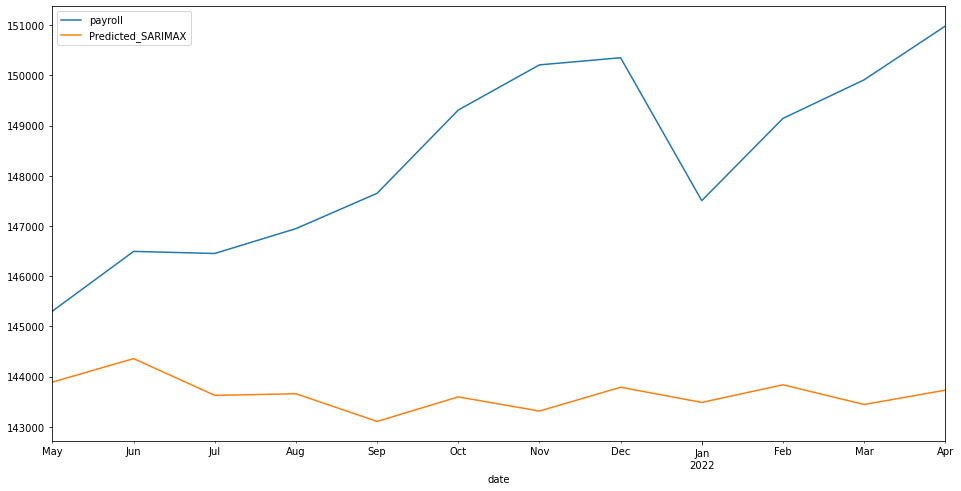

In [ ]:
test_data[[value_col, 'Predicted_SARIMAX']].plot(figsize=(16,8))

## Prophet

In [ ]:
from prophet import Prophet

In [ ]:
proph_train2, proph_val = create_proph_train_test(train2_data, val_data, date_col='date', value_col=value_col)
proph_train, proph_test = create_proph_train_test(train_data, test_data, date_col='date', value_col=value_col)

In [ ]:
prophet_model_filename = f"prophet_{suffix}_hyper_params"

In [ ]:
# run once then comment out 
# best_params = (0.8, 0.05, 0.1, 'multiplicative')
# save_hyperparam(prophet_model_filename, best_params)

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(prophet_model_filename)
except:
    pass 

In [ ]:
# # force hyperparamter tuning
# best_params = None

Find the best hyperparameters with train2 and validation data

In [ ]:
best_Prophet_RMSE_model, best_RMSE, best_Prophet_RMSE_params,\
 best_Prophet_WMAPE_model, best_WMAPE, best_Prophet_WMAPE_params\
 = find_best_Prophet_model(proph_train2, proph_val, val_data, value_col=value_col,freq='MS',\
                           best_params=best_params)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3483.7    0.00557674       1896.73      0.3355      0.3355      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3513.35   0.000259976       343.943      0.4654      0.4654      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3527.73    0.00277387       463.792      0.7003      0.7003      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3536.13    0.00042047       674.935      0.5025      0.5025      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     458       3537.65   3.32411e-05       208.976   2.144e-07       0.001      564  LS failed, Hessian reset 
     499       3538.23      0.001211    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5098179020622355
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3493.06    0.00138368       1306.44      0.2764      0.2764      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3523.72     0.0040642       417.243           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3532.78     0.0218879        565.06      0.7557           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3540.07    0.00203424       120.844       0.321      0.8433      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3543.62   0.000163618        150.77      0.1643           1      606   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5019032621523098
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3485.26    0.00275157       1194.91           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3515.51    0.00292212       442.995           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3527.98   0.000341775       242.017      0.8354      0.8354      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3534.73    0.00140966       468.592           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3537.51   0.000815635       325.758      0.5875      0.5875      566   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5026838817252114
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3496.44    0.00564264       1677.41     0.09186           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3524.17      0.051747       655.028           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3538.31     0.0129449       253.656      0.4342           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3542.85    0.00307797       651.828      0.2087           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       3542.91   1.88021e-05        140.27   1.289e-07       0.001      531  LS failed, Hessian reset

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5050272429867829
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3479.82    0.00322596       1092.62      0.4734      0.4734      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3512.48    0.00237879       251.105           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3527.71    0.00151736       128.162           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       3536.02   3.56705e-05       91.3857   3.469e-07       0.001      490  LS failed, Hessian reset 
     399       3536.02   2.39513e-05       101.297           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5048791461612803
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3506.06     0.0104614       1192.36           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3525.65    0.00937574       400.924           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3538.08    0.00068904        570.44           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3542.11    0.00166353       273.762      0.2621           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3543.56    0.00217017       135.541           1           1      595   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5024616627406555
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3498.88   0.000864432       423.661           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3532.94    0.00162589       461.471           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3552.84     0.0324617       3434.95           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3584.69     0.0019677       395.164           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3588.34   0.000205676       77.6624           1           1      548   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5336005172572176
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3505.76    0.00242194       576.321           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3548.73   0.000307122       463.053      0.2465     0.02465      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3577.25    0.00623647       399.701           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3596.52    0.00310404       676.802      0.3698           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3600.93    0.00279828       550.955           1           1      571   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5366793020253744
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3502.2    0.00313913        705.98           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3553.28   0.000254403       626.468           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3575.31   0.000906235       681.094      0.3531      0.9268      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3591.08    0.00207871       347.499           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3596.44    0.00253264       426.696           1           1      553   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5325608611565162
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3522.23    0.00172944       552.327           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3556.05     0.0141014       1094.06           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3594.41   0.000971076       257.689           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3599.63     0.0150543       572.705           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3604.59     0.0056676       174.681           1           1      584   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5342941902983414
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3508.59    0.00299631       592.571           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3552.24    0.00229769       1010.25       0.864       0.864      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3571.68    0.00255291       584.639      0.3911           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3586.23    0.00400964       750.734      0.9634      0.9634      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3593.81    0.00607616       1079.36       0.363           1      546   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5337591849966551
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3513.67    0.00365166       324.642           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3537.23    0.00412962        462.76           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3574.84   0.000905734       161.537           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3582.96    0.00439912       379.145           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3604.12    0.00101606       103.852           1           1      596   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5382832293698251
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3533.74    0.00538139       872.261           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3614.85    0.00141948        1610.8      0.2939      0.2939      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3650.85    0.00152576       660.255           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3667.07     0.0111413       175.814           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3672.38   0.000442693       452.254           1           1      563   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5506835130568428
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3528.99    0.00694923       515.963           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3615.02    0.00213846       850.611           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3635.14   0.000737565       733.623      0.7506      0.7506      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3669.22     0.0133638       1241.59           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3680.95    0.00119439        217.37           1           1      561   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5532325899355114
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3518.39     0.0475109       1581.72           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3546.39     0.0137022       1264.93           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3636.82     0.0376786       2976.54      0.6279      0.6279      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3653.61     0.0015048       181.402           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3672.27     0.0202163       420.403           1           1      552   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5502610221146815
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3531.59    0.00712337       1055.08       1.281      0.1281      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3595.11     0.0182483       891.644           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3654.37    0.00340415       446.975           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3660.59   0.000892867       140.377           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3671.74    0.00173375       260.526           1           1      585   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5532882748665925
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3522.44     0.0040701       2268.65     0.08958           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3566.42     0.0029645       459.987           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3646.72     0.0025951       520.096           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3655.47   0.000271358       378.603      0.2644      0.2644      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3663.21    0.00056337       302.764      0.9008      0.9008      552   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5504353207678744
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3531.42    0.00485915        1144.8           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3611.71     0.0419197       1982.62      0.7601      0.7601      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3652.78    0.00523737       652.194           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3667.35    0.00176415       474.658           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3670.52    0.00213479       145.643           1           1      574   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5518817593499631
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3518.81     0.0223923       1920.89           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3563.97    0.00567043       889.073           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3651.79     0.0234522       1272.91           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3671.74   0.000806305       259.733           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3678.31     0.0150709       1490.11      0.5005           1      545   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5534794448406729
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3523.03     0.0204468       1884.74           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3596.72     0.0187202       1779.78       1.059      0.1059      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3648.29    0.00740118       625.308           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3683.79     0.0378177       1372.37           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3698.19   0.000373514       216.729           1           1      565   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5549952735162564
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3524.36    0.00219285       1472.22      0.4748           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3577.8     0.0906304       2786.73           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3655.34    0.00669371        1120.7           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3671.07    0.00428665       909.123      0.9658      0.9658      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3681.64   0.000212617       211.474      0.7637      0.7637      562   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5530272103005555
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3534.81    0.00712815       543.426      0.2386           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3586.58    0.00609023       587.167           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3652.04     0.0609615       1975.82           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3664.02    0.00401921        571.46           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3681.95   0.000411591       219.035      0.9952     0.09952      569   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5547562044275788
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3527.47    0.00735245       1229.21      0.3835           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3564.79    0.00324078       974.138           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3605.97     0.0305079       1361.35           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3658.5      0.036262       2349.42           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3679.71     0.0326759       834.769           1           1      548   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5525747496871979
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3527.09    0.00368693       1155.89           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3603.1    0.00776025       474.345           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3663.3    0.00376582       1264.99      0.4247           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3684.52    0.00632476       972.166      0.5361      0.5361      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3693.44     0.0142834       459.596           1           1      569   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5555331015754239
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3617.5     0.0336186        4800.6           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3703.24    0.00150598       311.495           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3711.18    0.00036653       395.469           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3755.64     0.0329681       1829.06           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3767.05    0.00469023       875.106           1           1      561   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0725292242661084
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3650.94    0.00582187       2113.06           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3704.74      0.022493       1378.92           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3737.74    0.00640608       1622.18           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3779.68    0.00115337       1086.61      0.5226      0.5226      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3795.59    0.00327094       1682.45      0.3263           1      570   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0776155371711895
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3537.75     0.0954989       10070.8           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3685.85     0.0120238       1764.18           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3721.8   0.000289087        2491.5        0.17        0.17      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3749.87     0.0142679       3807.54      0.6471      0.6471      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3778.81   0.000234388        1510.5      0.2227      0.2227      551   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0713032980971966
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3663.63    0.00474599       1901.63           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3717.95    0.00172768       811.569       0.329       0.329      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3735.85    0.00589316       725.984      0.4948           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3762.55    0.00590977       963.449           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3790.85    0.00339461       753.663           1           1      560   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0797195480691286
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          3546     0.0157523       1412.31           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3685.07    0.00120566        1454.4           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3722.93    0.00436891       485.333           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3750.14     0.0181148       1828.48           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3766.85    0.00836828       410.357           1           1      551   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0695362969533102
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3658.7     0.0135288       3310.63           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3698.69    0.00193507       755.445           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3715.65    0.00494795       805.321           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3763.43    0.00914743         838.1           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3785.74    0.00858552       2749.41      0.1064       0.619      557   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0783999999339897
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3666.55     0.0123815       3656.42           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3747.72   0.000543122       1759.88      0.5543      0.5543      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3782.2   0.000621345       581.766           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3847.28   0.000750329       1610.39      0.2147      0.2147      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3862.2    0.00339618       1287.85      0.1333           1      561   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0796742526074652
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3673.31    0.00215821       4640.52      0.5298      0.5298      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3761.05   0.000527807       2022.94           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3804.65     0.0280114       4981.23      0.8069      0.8069      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3862.87   0.000647713       1394.25     0.09584           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3900.62    0.00212372       1359.05           1           1      559   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.085663850412099
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3655.15     0.0377812       6203.56           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3752.11    0.00692379       774.045      0.6537      0.6537      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3786.21   0.000552521       582.614           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3822.36    0.00173808       1038.45           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3847.21   0.000344588       434.228           1           1      551   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0811739016490225
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3670.07     0.0104303       1280.44           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3771.48     0.0254649        3135.5           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3805.91    0.00240493       869.125      0.4839      0.4839      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3832.52    0.00251514       328.137           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3881.23     0.0132735       2169.61           1           1      570   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.085723805753472
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3640.81    0.00951423       1725.26           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3735.52    0.00188359       1148.86           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3789.18    0.00784711       809.406           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3825.21    0.00609746       634.759           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3835.96     0.0015579       824.606           1           1      560   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0800449586961147
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3675.38    0.00515783       4743.86     0.08686           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3778.8    0.00181354        438.38           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3812.77    0.00261905       849.165           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3859.72    0.00400763        1915.3           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3886.7    0.00813447        2213.8           1           1      583   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0864207763569074
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3709.02    0.00923226        2284.6           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3773.21     0.0190392       1931.84           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3845.75    0.00412369       1385.46           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3875.34   0.000780433         285.4           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3948.09    0.00423434       1720.59           1           1      547   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.078743716360006
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3720.1    0.00276684       2946.52     0.04057           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3803.37    0.00326996        585.36           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          3847    0.00273239       792.849           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3953.3    0.00954698       2088.14           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3997.52    0.00559454       2337.57           1           1      561   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0856883481598858
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3673.39     0.0199327        3300.2           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3776.45    0.00362179       1008.05           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3823.31     0.0131373       2802.47           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3872.69    0.00103661       787.509           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3902.72     0.0477697       1665.53           1           1      553   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0808394301433135
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3721.13     0.0395015       1486.54           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3836.55    0.00454229        635.75           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3897.79     0.0252404       1213.89           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3955.97    0.00074455       885.745           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3992.89    0.00498398       1962.19           1           1      576   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0873131221755592
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3702.68     0.0129002       2026.76           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3759.54    0.00310768       2125.57      0.3307           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3812.13    0.00163934        913.15      0.8577      0.8577      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3877.16    0.00784212       1235.99           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3946.1     0.0470648        4751.7           1           1      552   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.081122900347813
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3708.03    0.00448445       1710.48           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3830.44    0.00510157       853.364           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3900.88    0.00322627       1577.52      0.1822      0.1822      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3969.17     0.0211231       1944.66           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4025.79    0.00122151       396.983           1           1      585   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0853478850498781
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3704.17     0.0079763       1150.21           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3773.76     0.0177832       3934.74      0.4517      0.4517      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3851.52     0.0774983       5048.37           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3898.82    0.00725334       1147.96           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3952.6    0.00137449       2263.07       0.238       0.238      554   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.080564173321123
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3707.66    0.00659332       1193.39      0.4322      0.4322      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3820.76    0.00517616       1113.36           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3906.72    0.00440577       789.758           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3963.18    0.00541039       470.425           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3991.45    0.00777494       863.771           1           1      572   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.086286179145048
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3685.57    0.00401085       1298.34           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3800.26     0.0167192       3555.94           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3828.4     0.0331175       2512.58           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3923.35    0.00121236       900.713           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3962.77    0.00642751       957.089           1           1      543   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.08140014888346
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3690.72     0.0328974       2442.62           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3771.77     0.0020947       357.855           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3878.41   0.000532556        673.66      0.2491      0.2491      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3943.53      0.031094       1975.82           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4011.48     0.0221771       4522.25           1           1      558   
    Iter      log prob  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0857301890452749
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3694.54      0.017806        3724.3      0.8223     0.08223      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3791.32     0.0111075       1945.24           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3843.91     0.0181454       2146.47           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3901.72     0.0024058       587.502           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3978.26     0.0319619       1699.76           1           1      562   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  1.0810642449593098
Initial log joint probability = -5.40273
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3704.85     0.0157691       1631.75      0.6814      0.6814      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3808.43    0.00205163       1395.37           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3872.81    0.00181418       578.334           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3950.6     0.0223281       822.196           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4029.93    0.00981865       1514.77           1           1      552   
    Iter      log prob

In [ ]:
best_Prophet_WMAPE_params, best_WMAPE

((0.8, 0.05, 0.1, 'multiplicative'), 0.5019032621523098)

In [ ]:
best_Prophet_RMSE_params, best_RMSE

((0.8, 0.05, 2, 'additive'), 6581.666740579663)

In [ ]:
# save best hyperparam to file 
save_hyperparam(prophet_model_filename, best_Prophet_RMSE_params)


best_Prophet_WMAPE_params, best_WMAPE

((0.8, 0.05, 0.1, 'additive'), 0.2522491958784298) 


best_Prophet_RMSE_params, best_RMSE

((0.8, 0.05, 0.1, 'multiplicative'), 2140.3478348419235)

We retrain with new data (full train data)

In [ ]:
changepoint_range, changepoint_prior_scale, seasonality_prio_scale, seasonality_mode\
         = best_Prophet_RMSE_params

model_Prophet = Prophet(changepoint_range=changepoint_range,\
                    changepoint_prior_scale=changepoint_prior_scale,\
                    seasonality_prior_scale=seasonality_prio_scale,\
                    seasonality_mode=seasonality_mode)
model_Prophet.fit(proph_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.93963


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99       3502.79      0.007683       1217.43      0.2678           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       3519.44   0.000171083       728.673   5.974e-07       0.001      225  LS failed, Hessian reset 
     199       3527.75    0.00344528       314.053      0.6667      0.6667      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       3531.85    4.7225e-05       252.601   2.332e-07       0.001      390  LS failed, Hessian reset 
     299        3535.4    0.00539191         317.4      0.3327           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       3540.56    8.6817e-05       400.771   2.339e-07       0.001      533  LS

In [ ]:
future = model_Prophet.make_future_dataframe(periods=len(proph_test), freq='MS')
forecast = model_Prophet.predict(future)

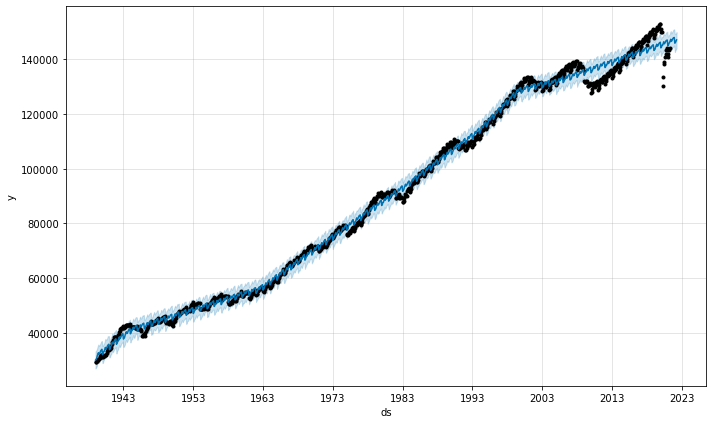

In [ ]:
fig1 = model_Prophet.plot(forecast)

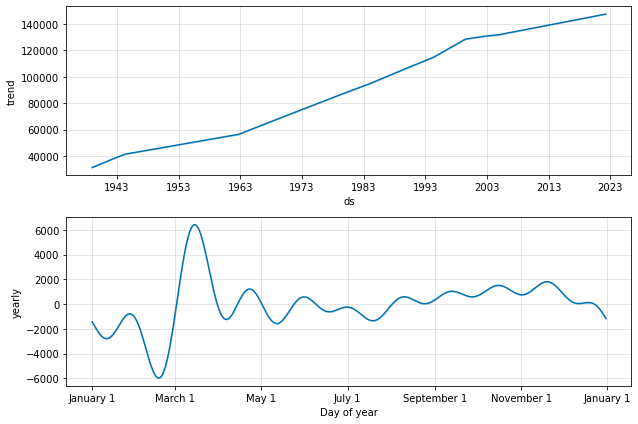

In [ ]:
fig2 = model_Prophet.plot_components(forecast)

In [ ]:
test_data['Predicted_Prophet'] = forecast[-(len(proph_test)):][['ds', 'yhat']].set_index('ds')

<AxesSubplot:xlabel='date'>

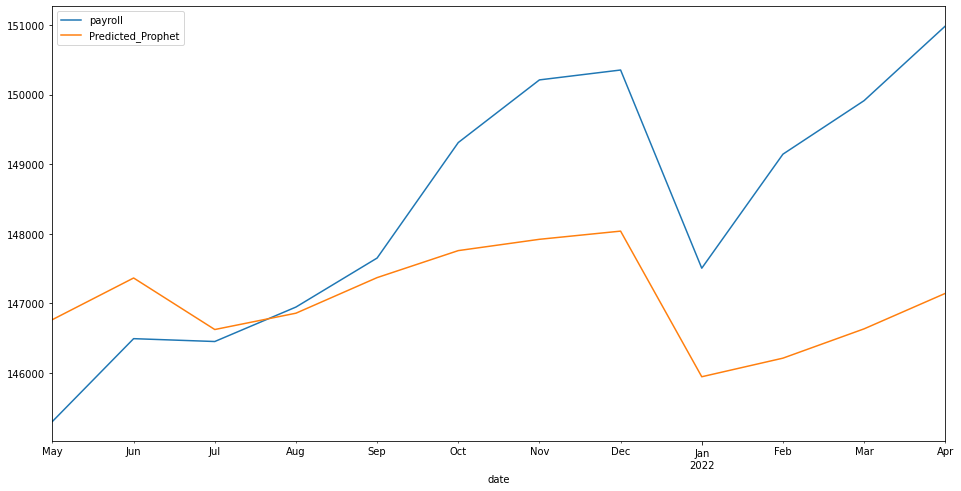

In [ ]:
test_data[[value_col, 'Predicted_Prophet']].plot(figsize=(16,8))

## Metrics

In [ ]:
timeseries_evaluation_metrics_func(test_data.payroll, test_data.Predicted_ETS)

Evaluation metric results:-
Mean Square Error is : 6454835.919993654
Mean Absolute Error is : 2071.0748356606878
Root Mean Square Error is : 2540.6369122709475
Mean Absolute Percentage Error is : 1.3919496047585604
R2 score is : -1.0442723612512652

Weighted MAPE: 0.013960247439943252


In [ ]:
timeseries_evaluation_metrics_func(test_data.payroll, test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 24661713.119659666
Mean Absolute Error is : 4582.7266232056745
Root Mean Square Error is : 4966.056093084297
Mean Absolute Percentage Error is : 3.0740851120079986
R2 score is : -6.810463214946839

Weighted MAPE: 0.030890239458275293


In [ ]:
timeseries_evaluation_metrics_func(test_data.payroll, test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 25687150.05344167
Mean Absolute Error is : 4703.95927349517
Root Mean Square Error is : 5068.249209879253
Mean Absolute Percentage Error is : 3.1561126003535676
R2 score is : -7.135223194583757

Weighted MAPE: 0.03170741794294438


In [ ]:
timeseries_evaluation_metrics_func(test_data.payroll, test_data.Predicted_Prophet)

Evaluation metric results:-
Mean Square Error is : 4377420.643135603
Mean Absolute Error is : 1719.9126580341592
Root Mean Square Error is : 2092.2286307035383
Mean Absolute Percentage Error is : 1.152013983475861
R2 score is : -0.3863466314635069

Weighted MAPE: 0.011593210379376695


### Conclusion:  
 For Non-Farm payroll, the Prophet model yield the smallest RMSE and WMAPE. 
 The order of model from best to worst are: Prophet, ETS, ARIMA and SARIMAX model. 
 